In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [2]:
# To-do
# 1. Do tests on ACF to determine frequency
# 2. ACF in reverse and determining fundamental frequency
# 3. Average of FFT
# 4. Improving interpolation
# 5. Speed up ACF
# 6. Windowing function
# 7. !!! Careful of Nyquist sampling rate

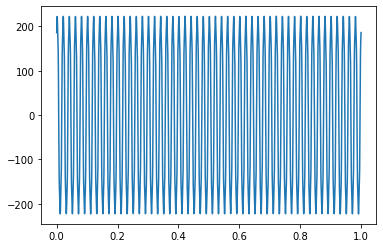

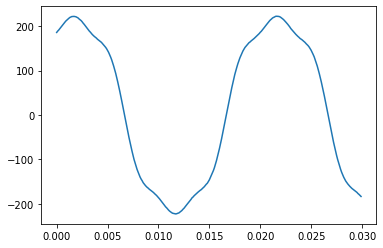

In [3]:
# --------------------------------------------------------
# Signal simulation
# --------------------------------------------------------

def simulateSignal(f0, A0, phi, fmod, Amod, tlen, fs):
    ''' 
    Simulates a signal with the following paramters
    
    f0: fundamental frequency [Hz]
    A0: amplitude of fundamental frequency
    phi: phase shift added to fundamental frequency wave form [deg]
    fmod: frequency of amplitude modulation [Hz]
    Amod: amplitude of modulating signal
    tlen: time duration of signal [s]
    fs: sampling rate of adc [samples/sec]
    
    Returns: array of simulated discrete signal
    
    Note: Signal has third and fifth harmonics of amplitude 1/10 and 1/15 of the fundamental frequency amplitude respectively.
    Change function as desired.
    '''
    
    t = np.linspace(0,tlen,int(fs*tlen)) # generate time axis for signal
    
    xmod = (A0 + Amod*np.sin(2*np.pi*fmod*t)) # generate modulating waveform
    x = np.sin(2*np.pi*f0*t + phi*np.pi/180) + (1/10)*np.sin(2*np.pi*3*f0*t + 3*phi*np.pi/180) + (1/15)*np.sin(2*np.pi*5*f0*t + 5*phi*np.pi/180) # create signal with harmonics
    x = (x*xmod) # modulate signal
    x = x + np.random.normal(0,0.2,int(fs*tlen)) # add noise
    
    return x



### Testing function
tlen = 1 # length of signal
fs = 10000

t = np.linspace(0,tlen,int(fs*tlen)) # generating time axis for signal
x = simulateSignal(50, 230, 60, 10, 0.05, tlen, fs)

plt.figure(); plt.plot(t,x)
plt.figure(); plt.plot(t[:300], x[:300]) # zoom in

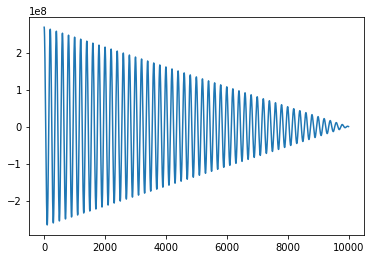

In [12]:
# --------------------------------------------------------
# Autocorrelation function computation for visualisation
# --------------------------------------------------------

def acf(x):
    '''
    Computes the autocorrelation function of a signal for development and visualisation purposes
    
    Parameters
    x: signal whose autocorrelation function is to be computed
    
    Returns: autocorrelation function of given signal
    '''
    
    R = np.zeros(len(x))
    
    # Autocorrelation with peak detection
    for m in range(len(x)):
        sum = 0
        for n in range(len(x)-m):
            sum += x[n] * x[n+m]
        R[m] = sum
        
    return R



### Testing
R = acf(x)
plt.plot(R)

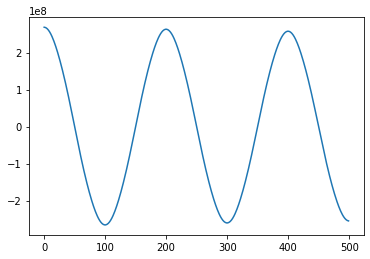

In [13]:
plt.plot(R[:500]) ################### it's cossomething times sin something ###############

53.84258262729766


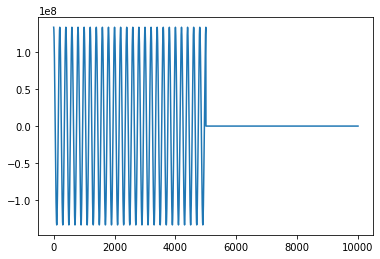

In [19]:
def acf_fixed_summation_interval(x):
    '''
    Computes the autocorrelation function of a signal but sums does summation over a fixed interval.
    This means peaks are the same height, but also, not all the samples in the signal are used to perform the
    autocorrelation.
    
    Parameters
    x: signal whose autocorrelation function is to be computed
    
    Returns: autocorrelation function of given signal with the summation interval fixed.
    '''
    
    R = np.zeros(len(x))
    N = len(x)
    
    # Autocorrelation with peak detection
    for m in range(int(N/2)):
        sum = 0
        for n in range(0,int(N/2)):
            sum += x[n] * x[n+m]
        R[m] = sum
        
        if (m == 0):
            A = sum ###################### amplitude of cosine ##################
        
        if (m == 10):
            print(((np.arccos(sum/A))/(10/10000))/(2*np.pi))
        
    return R



### Testing
R = acf_fixed_summation_interval(x)
plt.plot(R)

In [6]:
# --------------------------------------------------------
# Interpolation routines to obtain value of local peak
# --------------------------------------------------------

def quadratic_interpolate(a, b, c, b_pos):
    '''
    Performs quadratic interpolation for a set of three adjacent values to obtain location (x-coordinate) of peak
    
    a, b, c: three adjacent samples to which parabola is to be fitted
    b_pos: index of middle sample
    
    Returns: non-discrete 'index' of peak
    '''
    
    return b_pos+(0.5*(a-c)/(a-(2*b)+c))



def cubic_interpolate(p0, p1, p2, p3, p1_pos):
    '''
    Note: This function is still under development and has not been tested thus, may contain bugs.
    
    Performs cubic interpolation for a set of four adjacent values to obtain location (x-coordinate) of peak
    
    p0, p1, p2, p3: four adjacent samples to which cubic spline is to be fitted
    p1_pos: index of middle sample
    
    Returns: non-discrete 'index' of peak
    '''

    a = (-0.5*p0 + (3/2)*p1 - (3/2)*p2 + 0.5*p3)
    b = (p0 - (5/2)*p1 + 2*p2 - 0.5*p3)
    c = (-0.5*p0 + 0.5*p2)
    
    x1 = (((-2*b)+np.sqrt(np.power((2*b), 2)- 4*(3*a)*c))/(2*3*a))
    x2 = (((-2*b)-np.sqrt(np.power((2*b), 2)- 4*(3*a)*c))/(2*3*a))
    
    if (x1 > x2):
        return x1
    else:
        return x2

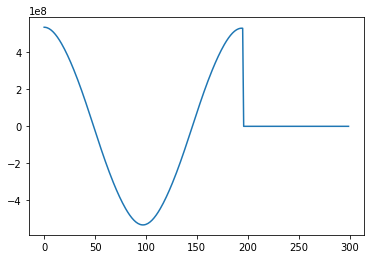

In [24]:
# --------------------------------------------------------
# Autocorrelation to obtain fundamental frequency
# --------------------------------------------------------

def macf_clip_signal(x):
    '''
    Clips given signal to create input signal that can be used for Modified AutoCorrelation Function (MACF) as detailed
    in https://ieeexplore.ieee.org/document/7129013.
    
    The frequency detection by autocorrelation can be done with or without this clipping, but clipping is said to improve
    frequency detection. After testing with canonical signal, it did not necessarily produce more accurate results. Perhaps, there
    are instances where it is better suited.
    
    Parameters:
    x: signal to be clipped
    
    Returns: central clipped signal
    '''
    CL = 0.5*np.amax(x) # set clipping threshold. Typically 50% of the maximum signal amplitude on the current segment.
    
    for i in range(len(x)):
        if (x[i] >= CL):
            x[i] -= CL
        elif (-CL < i < CL):
            x[i] = 0
        else:
            x[i] += CL
    
    return x       



def compute_f0_acf(x, fs):
    '''
    Determines fundamental frequency of a signal using autocorrelation
    
    Parameters:
    x: signal whose fundamental frequency is to be determined
    fs: sampling frequency of signal x
    
    The ACF of the signal is not actually fully computed or stored to save on space and time.
    Instead, a state machine is used to detect the second peak in the ACF (first peak is the maximum and is always at 0). 
    
    The states are:
    STATE 0 : set threshold under which value we'll ignore the data. NEW STATE = 1
    STATE 1 : check if signal is above threshold AND slope of the signal is positive. If so, move to STATE 2.
    STATE 2 : check if slope of signal has become negative or zero. If so, peak has been found. Move to STATE 3.
    STATE 3 : exit state machine.
    
    Returns: fundamental frequency (f0)
    '''
    
    thresh = 0
    f0 = 0
    STATE = 0
    sum = 0
    prev_sum = 0
    L = 0 # fundamental frequency period expressed in samples
    
    L_det = 0
    count = 0
    
    R = np.zeros(len(x))
    
    # Autocorrelation with peak detection
    for m in range(len(x)):
        prev_prev_sum = prev_sum
        prev_sum = sum
        sum = 0
        
        for n in range(len(x)-m):
            sum += x[n] * x[n+m] # not storing ACF in order to store memory
        
        # State machine to obtain three adjacent points around peak for quadratic interpolation
        if (STATE == 2 and (sum - prev_sum) <= 0): # if gradient change, obtain current and previous two values
            L = quadratic_interpolate(prev_prev_sum, prev_sum, sum, m-1)
            STATE = 3
            break
            
        if (STATE == 1 and (sum > thresh) and (sum - prev_sum) > 0):
            STATE = 2
            
        if (m == 0):
            thresh = sum * 0.5 # peaks to be detected are above half the first peak (maximum value of ACF)
            STATE = 1
            
    
    # Computing frequency in Hz
    f0 = fs/L;
    
    if (f0 < 40 and f0 > 60):
        print('Fundamental frequency too far from 50 Hz!')
    
    return f0


### Testing
fs = 10000
f0_simulation = 51.523
x = simulateSignal(f0_simulation, 230, 0, 10, 0.05, 2, fs)  # simulate signal with 3rd and 5th harmonics
plt.plot(x[:500])
# x = x[700:] # adding phase shift to signal

f0 = compute_f0_acf(x, fs)
print(f0)

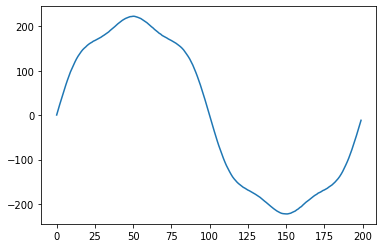

In [5]:
# --------------------------------------------------------
# Truncation of signal to period given by fundamental 
# frequency
# --------------------------------------------------------
def start_signal_from_zero(x):
    '''
    Truncates signal to begin from value of 0. This may help decrease inaccuracy in computation of
    Fourier Transform by removing a step jump at the beginning. If a value of 0 does not exist, signal starts 
    at value after sign change.
    
    Parameters
    x: signal to be truncated to start from a value of 0
    
    Returns: original signal with any leading non-zero values discarded.
    '''
    
    for i in range(len(x)):
        if (x[i] > 0 and x[i+1] < 0):
            return x[i+1:]
        elif (x[i] < 0 and x[i+1] > 0):
            return x[i+1:]
        elif (x[i] == 0):
            return x[i:]
    

def truncate_to_T0_duration(x, f0, fs):
    '''
    Truncates given signal duration to the period T0 [s] obtained from the fundamental frequency.
    This may help decrease inaccuracy in computation of Fourier Transform.
    
    Parameters
    x: signal to be truncated
    f0: fundamental frequency of the given signal
    
    Returns: signal truncated of the duration of fundamental period
    '''
    
    T0 = 1/f0
    samples = int(np.round(T0*fs))
    
    return x[0:samples]



### Testing
y = start_signal_from_zero(x)
y = truncate_to_T0_duration(y,f0,fs)
plt.plot(y)

complex value at  50.00250090803272  Hz =  (-0.0028462372627996242+229.98970446760634j)
magnitude at  50.00250090803272  Hz =  229.98970448521814
phase at  50.00250090803272  Hz =  90.0007090638384

complex value at (FFT) 50.00250090803272  Hz =  (36107.52580094082+2299588.0596545604j)
magnitude at (FFT) 50.00250090803272  Hz =  2299871.517612515
phase at (FFT) 50.00250090803272  Hz =  89.10043068988786


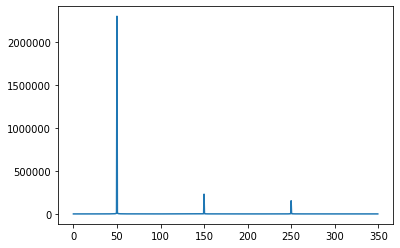

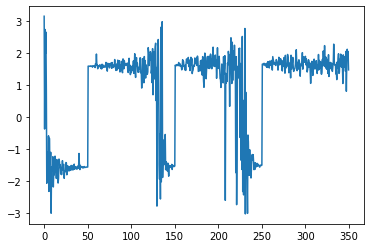

In [38]:
# -----------------------------------------------------------
# Magnitude and phase computation for specific frequencies
# -----------------------------------------------------------

def normalized_spectral_value(x, f, fs):
    '''
    Uses Discrete Time Fourier Transform formula to obtain the normalized complex value of the signal's spectrum at a particular
    frequency.
    
    The normalization routine performed here for the Fourier Transform to obey Parseval's relation is based on the article:
    http://www.dspguide.com/ch10/7.htm    
    
    Parameters:
    x: time domain signal whose frequency component is to be computed
    f: frequency (Hz) of interest
    fs: sample rate
    
    Returns: complex value of frequency component
    '''
    R = 0 # real part
    I = 0 # complex part
    frel = f/fs # relative frequency. Equation of DTFT actually uses cycles/sample not cycles/sec (i.e. Hz).
    
    for n in range(len(x)):
        R += x[n] * np.cos(2*np.pi*frel*n)
        I += x[n] * np.sin(2*np.pi*frel*n)
    
    X_f = np.complex(R, I)
    
    # Normalising
    if (f == 0): # for DFT if f corresponds to sample at 0 or sample at +/-N/2. Because DTFT is used here, there is no way of knowing what frequency is at N/2
        X_f = X_f/2
    X_f = X_f/(len(x)/2) # dividing all points in DTFT by N/2
    
    return  X_f


### Testing
X_f0 = normalized_spectral_value(x, f0, fs)
print("complex value at ", f0, " Hz = ", X_f0)
print("magnitude at ", f0, " Hz = ", np.abs(X_f0))
print("phase at ", f0, " Hz = ", np.angle(X_f0)*180/np.pi)

# Note!!! The Fourier Transform is based on the cosine; therefore, the reference phase i.e. phase = 0 is at phase = 0 of a cos
# signal. If initial signal was a sin signal, it is initially 90 out of phase.

# Verifying with FFT
X = np.fft.fft(x)
freq = np.fft.fftfreq(len(x), 1/fs)
plt.plot(freq[:700], np.abs(X)[:700])
plt.figure(); plt.plot(freq[:700], np.angle(X)[:700])

Xmag = abs(X)
f0_index = np.argmax(Xmag)
print("\ncomplex value at (FFT)", f0, " Hz = ", X[f0_index])
print("magnitude at (FFT)", f0, " Hz = ", np.abs(X[f0_index]))
print("phase at (FFT)", f0, " Hz = ", (np.angle(X[f0_index])*180/np.pi))

In [ ]:
# --------------------------------------------------------
# Dataset Simulation for GPT
# --------------------------------------------------------

f0 = 50                                             # fundametal frequency [Hz]
fs = 9765.625                                       # sampling frequency of ADC
tlen = 5                                            # duration of measurement interval
trunc = 10000                                       # truncation of plot

v1 = simulateSignal(f0, 230, 10, 0.05, tlen, fs)    # line 1 voltage
v2 = simulateSignal(f0, 235, 10, 0.05, tlen, fs)    # line 2 voltage
v3 = simulateSignal(f0, 50, 10, 0.05, tlen, fs)     # line 3 voltage
v4 = simulateSignal(f0, 20, 10, 0.05, tlen, fs)     # line 4 voltage

i1 = simulateSignal(f0, 2, 10, 0.05, tlen, fs)      # line 1 current
i2 = simulateSignal(f0, 0.5, 10, 0.05, tlen, fs)    # line 2 current
i3 = simulateSignal(f0, 0.88, 10, 0.05, tlen, fs)   # line 3 current
i4 = simulateSignal(f0, 0.6, 10, 0.05, tlen, fs)    # line 4 current

r1 = 500                                            # line 1 resistance
r2 = 1000                                           # line 2 resistance
r3 = 5000                                           # line 3 resistance
r4 = 2000                                           # line 4 resistance